In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import time
from scipy.interpolate import LSQUnivariateSpline

In [2]:
random.seed(42)

In [3]:
#in this network we combine Transformer 1 and Transformer 2

In [4]:
class Embedding(nn.Module):
    def __init__(self, embed_dim):
        super(Embedding, self).__init__()
        
        self.linear = nn.Linear(1, embed_dim)
    
    #embed the inputs into an embed_dim dimensional embedding space using a linear layer
    def forward(self, x):
        x = x.unsqueeze(-1)
        out = self.linear(x)
        return out 

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        super(PositionalEmbedding, self).__init__()
        
        self.embed_dim = embed_model_dim
        
        pe = torch.zeros(max_seq_len, self.embed_dim) 
        
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2*i)/self.embed_dim)))
                pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe) 
        
    def forward(self, x):
        x *= math.sqrt(self.embed_dim) 
        seq_len = x.size(2)
        x += torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False) 
        return x

In [6]:
class FeatureTransformation(nn.Module):
    def __init__(self, num_features, hidden_layer):
        super(FeatureTransformation, self).__init__()
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(num_features, hidden_layer),
                        nn.Tanh()
        )
    
    def forward(self, z):
        z = self.feed_forward(z)
        return z 

In [7]:
class ForgetGate(nn.Module):
    def __init__(self, hidden_layer):
        super(ForgetGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, h_tminus1, z_t):
        zt = self.linear1(z_t)
        htminus1 = self.linear2(h_tminus1)
        sum_zh = (zt + htminus1)
        ft = self.sigmoid(sum_zh)
        return ft 

In [8]:
class InputGate(nn.Module):
    def __init__(self, hidden_layer):
        super(InputGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.linear3 = nn.Linear(hidden_layer, hidden_layer)
        self.linear4 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, h_tminus1, z_t):
        zt_1 = self.linear1(z_t)
        htminus1_1 = self.linear2(h_tminus1)
        sum_zh_1 = zt_1 + htminus1_1
        it1 = self.sigmoid(sum_zh_1)

        zt_2 = self.linear3(z_t)
        htminus1_2 = self.linear4(h_tminus1)
        sum_zh_2 = zt_2 + htminus1_2
        it2 = self.tanh(sum_zh_2)

        out = it1*it2
        return out 

In [9]:
class OutputGate(nn.Module):
    def __init__(self, hidden_layer):
        super(OutputGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, h_tminus1, z_t):
        zt = self.linear1(z_t)
        htminus1 = self.linear2(h_tminus1)
        sum_zh = zt + htminus1
        ot = self.sigmoid(sum_zh)
        return ot 

In [10]:
class LSTMCell(nn.Module):
    def __init__(self, hidden_layer):
        super(LSTMCell, self).__init__()
        
        self.forget_gate = ForgetGate(hidden_layer)
        self.input_gate = InputGate(hidden_layer)
        self.output_gate = OutputGate(hidden_layer)
        self.tanh = nn.Tanh()
    
    def forward(self, h_tminus1, c_tminus1, z_t):
        ft = self.forget_gate(h_tminus1, z_t)
        it = self.input_gate(h_tminus1, z_t)
        ot = self.output_gate(h_tminus1, z_t)
        c_t = ft*c_tminus1 + it
        tanc_t = self.tanh(c_t)
        h_t = ot * tanc_t
        return h_t, c_t 

In [11]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_layer):
        super(LSTM, self).__init__()
        
        self.feature_transformation = FeatureTransformation(num_features, hidden_layer)
        self.lstm_cell = LSTMCell(hidden_layer)
        self.hidden_layer = hidden_layer
        
    def forward(self, z):
        z_t = self.feature_transformation(z) 
        batch_size = z_t.size(0)
        num_stocks = z_t.size(1)
        h = torch.zeros(batch_size, num_stocks, self.hidden_layer)
        c = torch.zeros(batch_size, num_stocks, self.hidden_layer)
        T = z.size(2)
        h_outputs = []
        for t in range(T):
            h_t, c_t = self.lstm_cell(h, c, z_t[:, :, t])
            h_outputs.append(h_t)
            h = h_t.clone().detach()  
            c = c_t.clone().detach()  
        return torch.stack(h_outputs) 

In [12]:
class AttentionLSTM(nn.Module): 
    def __init__(self, num_features, hidden_layer, input_size):
        super(AttentionLSTM, self).__init__()
        
        self.lstm = LSTM(num_features, hidden_layer)
        self.W = torch.nn.Parameter
        self.W.requires_grad = True
        self.b = torch.nn.Parameter
        self.b.requires_grad = True
        self.input_size = input_size
        self.hidden_layer = hidden_layer
    
    def context_norm(self, h_c, batch_size, num_stocks): 
        mean = torch.mean(h_c)
        std = torch.std(h_c)
        hc_adj = (h_c-mean)/std
        W = self.W(torch.randn((batch_size, num_stocks, self.hidden_layer)))
        b = self.b(torch.randn((batch_size, num_stocks, self.hidden_layer)))
        hc_adj *= W
        hc_adj += b
        return hc_adj
    
    def forward(self, z):
        h = self.lstm(z) 
        batch_size = z.size(0)
        num_stocks = z.size(1)
        sum_exp = torch.zeros(batch_size, num_stocks)
        for i in range(len(h)):
            sum_exp1 = sum_exp + torch.exp(torch.sum(h[i]*h[-1], 2))
            sum_exp = sum_exp1
        alpha = torch.zeros(self.input_size, batch_size, num_stocks) 
        for i in range(len(h)):
            alpha_i = alpha[i] + torch.exp(torch.sum(h[i]*h[-1], 2))/sum_exp
            alpha[i] = alpha_i
        alpha = alpha.unsqueeze(3) 
        
        h_alpha = h * alpha 
        h_c = torch.zeros((batch_size, num_stocks, self.hidden_layer))
        for i in range(len(h)):
            h_c2 = h_c + h_alpha[i]
            h_c = h_c2
        
        h_c1 = self.context_norm(h_c, batch_size, num_stocks)
        return h_c1

In [13]:
class MLContext(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size, beta):
        super(MLContext, self).__init__()
        
        self.attention_lstm = AttentionLSTM(num_features, hidden_layer, input_size)
        self.beta = beta
        
    def forward(self, z, market_index):
        h_c = self.attention_lstm(z)
        h_i = self.attention_lstm(market_index)
        h_m = h_c + self.beta*h_i
        return h_m

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        super(MultiHeadAttention, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.n_heads) 
        
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False) 
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False) 
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False) 
        
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 
    
    #this section is modified to accomodate the use in both networks
    def forward(self, key, query, value, mask=None, trans=True):
        batch_size = key.size(0)
        num_stocks = key.size(1)
        seq_length = key.size(2)
        
        seq_length_query = query.size(2)
        
        if trans:
            key = key.view(batch_size, num_stocks, seq_length, self.n_heads, self.single_head_dim) 
            query = query.view(batch_size, num_stocks, seq_length_query, self.n_heads, self.single_head_dim)
            value = value.view(batch_size, num_stocks, seq_length, self.n_heads, self.single_head_dim)

            k = self.key_matrix(key).transpose(3, 2) 
            q = self.query_matrix(query).transpose(3, 2)   
            v = self.value_matrix(value).transpose(3, 2) 
        
        else:
            key = key.view(batch_size, num_stocks, self.n_heads, self.single_head_dim) 
            query = query.view(batch_size, num_stocks, self.n_heads, self.single_head_dim)
            value = value.view(batch_size, num_stocks, self.n_heads, self.single_head_dim)

            k = self.key_matrix(key).transpose(1, 2) 
            q = self.query_matrix(query).transpose(1, 2)   
            v = self.value_matrix(value).transpose(1, 2) 

        k_adjusted = k.transpose(-1, -2) 

        product = torch.matmul(q, k_adjusted)

        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20")) 

        product = product / math.sqrt(self.single_head_dim) 

        scores = F.softmax(product, dim=-1)
        scores1 = torch.matmul(scores, v) 
        if trans:
            concat = scores1.transpose(1,2).contiguous().view(batch_size, num_stocks, seq_length_query, self.single_head_dim*self.n_heads) 
        
        else:
            concat = scores1.transpose(1,2).contiguous().view(batch_size, num_stocks, self.single_head_dim*self.n_heads) 

        
        output = self.out(concat)

        return output, scores


In [15]:
#this is the same as FinalOutput from network 2
class CorrelationsOutput(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size, beta, n_heads, expansion_factor=4, dropout_value=0.2):
        super(CorrelationsOutput, self).__init__()
        
        self.mlcontext = MLContext(num_features, hidden_layer, input_size, beta)
        self.multihead = MultiHeadAttention(hidden_layer, n_heads)
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(hidden_layer, expansion_factor*hidden_layer),
                        nn.ReLU(),
                        nn.Linear(expansion_factor*hidden_layer, hidden_layer)
        )
        
        self.tanh = nn.Tanh()
        
        self.norm1 = nn.LayerNorm(hidden_layer)
        self.norm2 = nn.LayerNorm(hidden_layer)
        
        self.dropout1 = nn.Dropout(dropout_value)
        
    def forward(self, z, market_index):
        h_m = self.mlcontext(z, market_index)
        scores = self.multihead(h_m, h_m, h_m, trans=False)[1]
        return scores

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, dropout_value, expansion_factor = 4, n_heads = 8):
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(embed_dim, expansion_factor * embed_dim),
                        nn.ReLU(),
                        nn.Linear(expansion_factor * embed_dim, embed_dim)
        )
        
        self.dropout1 = nn.Dropout(dropout_value)
        self.dropout2 = nn.Dropout(dropout_value)
    
    def forward(self, key, query, value):
        attention_out = self.attention(key, query, value)[0]
        attention_residual_out = attention_out + query
        norm1_out = self.dropout1(self.norm1(attention_out)) 
        
        feed_fwd_out = self.feed_forward(norm1_out)
        feed_fwd_residual_out = feed_fwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))
        
        return norm2_out

In [30]:
#here we compute the attention scores from Transformer 2, and apply them to the embedded input vectors for the Transformer2 encoder
class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, input_size, embed_dim, num_features, beta, num_layers=2, expansion_factor=4, n_heads=8): 
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(embed_dim) 
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)
        self.correlations = CorrelationsOutput(num_features, embed_dim, input_size, beta, n_heads, expansion_factor, dropout_value)

        self.dropout = nn.Dropout(dropout_value)
        self.norm = nn.LayerNorm(embed_dim)
        self.heads = n_heads
        self.embed = embed_dim

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, dropout_value, expansion_factor, n_heads) for i in range(num_layers)])

    def forward(self, x, market_index):
        batch_size = x.size(0)

        embed_out = self.embedding_layer(x[:,:,:,0].squeeze(dim=-1))
        posit_out = self.positional_encoder(embed_out)
        correl_out = self.correlations(x[:,:,:,1:], market_index).unsqueeze(1)

        posit_out1 = posit_out.view(batch_size, self.heads, posit_out.size(1), posit_out.size(2), int(self.embed/self.heads)).permute(0,3,1,2,4)

        product = torch.matmul(correl_out, posit_out1)
        scores1 = F.softmax(product, dim=-1)
        concat = scores1.permute(0,3,1,2,4).contiguous().view(batch_size, posit_out.size(1), posit_out.size(2), self.embed) 

        out = self.dropout(self.norm(concat))
        for layer in self.layers:
            out = layer(out, out, out)

        return out

In [31]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, dropout_value, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()
        
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout_value)
        self.transformer_block = TransformerBlock(embed_dim, dropout_value, expansion_factor, n_heads)
        
    def forward(self, key, x, value, mask):
        attention = self.attention(x, x, x, mask=mask)[0]
        x = self.dropout(self.norm(attention + x))
        out = self.transformer_block(key, x, value)
        
        return out

In [32]:
#here we compute the attention scores from Transformer 2, and apply them to the embedded input vectors for the Transformer2 decoder
class TransformerDecoder(nn.Module):
    def __init__(self, decoder_input_size, embed_dim, seq_len, target_output_size, dropout_value, num_features, beta, num_layers=2, expansion_factor=4, n_heads=8): ###batch size after target output
        super(TransformerDecoder, self).__init__()
        
        self.embedding = Embedding(embed_dim) 
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)
        self.correlations = CorrelationsOutput(num_features, embed_dim, decoder_input_size, beta, n_heads, expansion_factor, dropout_value)
        self.heads = n_heads
        self.embed = embed_dim
        
        self.fst_attention = DecoderBlock(embed_dim, dropout_value, expansion_factor=4, n_heads=8)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, dropout_value, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc1_out = nn.Linear(embed_dim, 1)
        self.fc2_out = nn.Linear(decoder_input_size, target_output_size)
        self.dropout = nn.Dropout(dropout_value)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x, enc_out, mask, market_index):
        batch_size = x.size(0)
        embed_out = self.embedding(x[:,:,:,0].squeeze(dim=-1)) 
        posit_out = self.position_embedding(embed_out)
        correl_out = self.correlations(x[:,:,:,1:], market_index).unsqueeze(1)
        
        posit_out1 = posit_out.view(batch_size, self.heads, posit_out.size(1), posit_out.size(2), int(self.embed/self.heads)).permute(0,3,1,2,4)
            
        product = torch.matmul(correl_out, posit_out1)
        scores1 = F.softmax(product, dim=-1)
        concat = scores1.permute(0,3,1,2,4).contiguous().view(batch_size, posit_out.size(1), posit_out.size(2), self.embed) #32 x 10 x 512

        pre_out = self.dropout(self.norm(concat))
        
        for layer in self.layers:
            decod_out = layer(enc_out, pre_out, enc_out, mask=None)
        
        out = self.fc1_out(decod_out)
        out = torch.squeeze(out, dim=-1)
        out = self.fc2_out(out)
        out = torch.squeeze(out, dim=-1)
        return out

In [33]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, input_size, decoder_input_size, target_output_size, seq_length, num_features, beta, num_layers=2, dropout_value=0.2, expansion_factor=4, n_heads=8): ###batch_size, after target output
        super(Transformer, self).__init__()
        
        self.decoder_input_size = decoder_input_size
        
        self.encoder = TransformerEncoder(seq_length, input_size, embed_dim, num_features, beta, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads) ###batch_size=batch_size, after embed dim
        self.decoder = TransformerDecoder(decoder_input_size, embed_dim, seq_length, target_output_size, dropout_value, num_features, beta, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads) ###batch_size=batch_size, after target output
        
    def make_trg_mask(self, trg):
        batch_size, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(batch_size, 1, trg_len, trg_len) #returns lower triangular matrix
        return trg_mask
    
    def decode(self, src, trg):
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size, seq_len = src.shape[0], src.shape[1]
        
        out = trg
        for i in range(seq_len):
            out = self.decoder(out, enc_out, trg_mask)
            
            out = out[:, -1, :]
            
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out, axis=0)
            
        return out_labels
    
    def forward(self, src, market_index):
        enc_out = self.encoder(src, market_index) 
        
        outputs = self.decoder(src[:,:,1:,:], enc_out, 0, market_index[:,:,1:,:]) 
        return outputs

In [34]:
input_size = 10
decoder_input_size = 9
target_output_size = 1
num_layers = 6
seq_length = 10 
batch_size = 16
dropout_value = 0.2
num_training_stocks = 5

num_features = 11
beta = 0.1


model = Transformer(embed_dim=32, input_size=input_size, 
                    decoder_input_size=decoder_input_size, target_output_size=target_output_size, seq_length=seq_length, num_features=num_features, beta = beta, 
                    num_layers=num_layers, dropout_value=dropout_value, expansion_factor=4, n_heads=8) 

current_path = os.path.join(r'C:\Users', 'barne', 'Diss', 'Stocks', 'Code', 'Network 1')


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
class CustomDataset():
    def __init__(self, inputs, labels, transform=None, target_transform=None):
        self.labels = labels
        self.inputs = inputs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inpt = self.inputs[idx]
        label = self.labels[idx]
        if self.transform:
            inpt = self.transform(inpt)
        if self.target_transform:
            label = self.target_transform(label)
        return inpt, label

In [23]:
current_path = os.path.join(r"C:\\", "Users", "barne", "Diss", "Stocks", "Code", "Network 2")
MI_path = os.path.join(current_path, "Market Index data")
years = [f for f in listdir(MI_path) if isfile(join(MI_path, f))]
MI_data = []
for year in years:
    data2 = list(reversed(open(os.path.join(MI_path, year)).read().splitlines()[1:]))
    for i in range(len(data2)):
        lst = data2[i].split(',"')
        for j in range(len(lst)-1):
            lst[j+1] = lst[j+1][:-1]
            if ',' in lst[j+1]:
                idx = lst[j+1].find(',')
                lst[j+1] = lst[j+1][:idx] + lst[j+1][idx+1:]
        lst += ['volume', lst[-1]]
        data2[i] = ','.join(lst)
    MI_data+=data2


In [87]:
#build the dataset in the same way as for network 2
mypath = os.path.join(current_path, "..", "Network 2", "Adv-ALSTM-master", "data", "kdd17", "price_long_50")
stocks = [f for f in listdir(mypath) if isfile(join(mypath, f))]

means = []
stds = []
feature_vectors = {}
for i in range(num_training_stocks+1):
    if i == 0:
        data = MI_data
    else:
        data = open(os.path.join(mypath, stocks[i-1])).read().splitlines()
        data = list(reversed(data[1:]))
    date1 = data[0].split(',')[0].replace('-', '/').split('/')
    date2 = data[1].split(',')[0].replace('-', '/').split('/')
    year = 0
    month = 0
    day_of_month = 0
    for i in range(len(date1)):
        if len(date1[i]) == 4:
            year = i
        elif date1[i] == date2[i]:
            month = i
        else:
            day_of_month = i
    
    previous_adjclose = []
    previous_close = 0
    previous_date = []        
    closing_prices = []
    
    for day in data:
        lst = day.split(',')
        close_price = float(lst[4])
        closing_prices.append(close_price)
    
    mean = np.mean(closing_prices)
    means.append(mean)
    std = np.std(closing_prices)
    stds.append(std)
    
    for day in data[:30]: 
        lst = day.split(',')
        adj_close = float(lst[6])
        previous_adjclose.append(adj_close)
        if day == data[29]:
            previous_close = float(lst[4]) 
    for day in data[31:]:    
        lst = day.split(',')
        date_lst = lst[0].replace('-', '/').split('/')   
        date = '/'.join([str(int(date_lst[day_of_month])), str(int(date_lst[month])), str(int(date_lst[year]))])
       
        open_price = float(lst[1])
        close_price = float(lst[4])
        high = float(lst[2])
        low = float(lst[3])
        adj_close = float(lst[6])
        feature_vector = [float((close_price-mean)/std), (open_price/close_price)-1, (high/close_price)-1, (low/close_price)-1, (close_price/previous_close)-1, (adj_close/previous_adjclose[-1])-1]
        for i in range(5, 35, 5):
            feature_vector.append((sum(previous_adjclose[-i:])/(i*adj_close))-1)
        if date not in feature_vectors.keys():
            feature_vectors[date] = [feature_vector]
        else:
            feature_vectors[date].append(feature_vector)
        previous_close = close_price
        previous_adjclose.append(adj_close)


year_lookup = {} 
for date in feature_vectors.keys():
    
    if len(feature_vectors[date]) != num_training_stocks+1:
        continue
    else:
        date_lst = date.split('/')
        year = int(date_lst[2])
        if year not in year_lookup.keys():
            year_lookup[year] = [feature_vectors[date]]
        else:
            year_lookup[year].append(feature_vectors[date])

train_feature_vectors = []
val_feature_vectors = []
test_feature_vectors = []
years = sorted(list(year_lookup.keys()))

for year in range(years[-2], years[-1]+1):
    test_feature_vectors += year_lookup[year]
training_cut_off = years[math.ceil(0.75*len(years))-1]
for year in range(years[0], training_cut_off):
    train_feature_vectors += year_lookup[year]
for year in range(training_cut_off, years[-1]):
    val_feature_vectors += year_lookup[year]
    

block_size = input_size
def build_dataset(feature_vectors):
    X, Y = [], []
    for i in range(len(feature_vectors)-block_size):
        X.append(feature_vectors[i:i+block_size])
        day = feature_vectors[i+block_size][1:]
        Y_builder = []
        for j in range(len(day)):
            Y_builder.append(day[j][0])
        Y.append(Y_builder)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

Xtr, Ytr = build_dataset(train_feature_vectors)
Xval, Yval = build_dataset(val_feature_vectors)
Xte, Yte = build_dataset(test_feature_vectors)

training_data = CustomDataset(Xtr, Ytr)
val_data = CustomDataset(Xval, Yval)

trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

test_data = CustomDataset(Xte, Yte)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [496]:
epochs = 1000

train_losses, val_losses = [], []
for e in range(1, epochs+1):
    start_time = time.time()
    tot_train_loss = 0
    model.train()
    for x, y in trainloader:
        if len(y) != batch_size:
            continue
        z = torch.transpose(x, 1, 2)
        market_index = z[:,0,:,1:]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]     
           
        optimizer.zero_grad()
        
        outputs = model(z, market_index)
        loss = criterion(outputs, y.float())
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        tot_val_loss = 0
        with torch.no_grad():
            model.eval()
            for x, y in valloader:
                if len(y) != batch_size:
                    continue
                z = torch.transpose(x, 1, 2)
                market_index = z[:,0,:,1:]
                market_index = torch.unsqueeze(market_index, 1)
                z = z[:, 1:]
                outputs = model(z, market_index)
                loss = criterion(outputs, y)
                tot_val_loss += loss.item()

        train_loss = tot_train_loss / len(trainloader.dataset)
        val_loss = tot_val_loss / len(valloader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.5f}.. ".format(train_loss),
              "Test Loss: {:.5f}.. ".format(val_loss), 
              "Time taken: {:.3f}..".format(time.time()-start_time))
            
    if e%10 == 0:
        torch.save(model.state_dict(), os.path.join(current_path, "Checkpoints", '1checkpoint' + str(e) + '.pth'))

Epoch: 1/1000..  Training Loss: 0.00096..  Test Loss: 0.04102..  Time taken: 15.372..
Epoch: 2/1000..  Training Loss: 0.00095..  Test Loss: 0.04219..  Time taken: 15.536..
Epoch: 3/1000..  Training Loss: 0.00092..  Test Loss: 0.04141..  Time taken: 15.308..
Epoch: 4/1000..  Training Loss: 0.00097..  Test Loss: 0.04151..  Time taken: 15.039..


KeyboardInterrupt: 

In [142]:
#best checkpoint finder
best_checkpoint = 0
losses = {}
scores = {}
for c in range(1, 151):
    print(c)
    with torch.no_grad():
        model.eval()
        checkpoint = 10*c
        state_dict = torch.load(os.path.join(current_path, "20-4-24", "Network2", "combinedCheckpoints", 'checkpoint' + str(checkpoint) + '.pth'))
        model.load_state_dict(state_dict)
        inpts = test_data[0][0][:,1:6,0]
        outs = test_data[0][0][:,1:6,0]
        for x, y in testloader:

            z = torch.transpose(x, 1, 2)
            market_index = z[:,0,:,1:]
            market_index = torch.unsqueeze(market_index, 1)
            z = z[:, 1:]     

            outputs = model(z, market_index)

            outs = torch.cat((outs,outputs))

            inpts = torch.cat((inpts, y))

    prods = []
    mses = []
    for s in range(5):
        inpt = inpts[:,s]
        out = outs[:,s]

        prod1 = 1
        for j in range(1, len(inpt)):
            sign = 1
            if out[j]-out[j-1] < 0:
                sign = -1
            prod1 *= (1+((inpt[j]-inpt[j-1])/inpt[j-1]*sign))
        prods.append(prod1)


        total_loss = 0.0
        for j in range(len(inpt)-10):
            total_loss += (inpt[j+10]-out[j+10])**2
        total_loss/=(len(inpt)-10)
        mses.append(total_loss)

    losses[checkpoint] = np.mean(mses)
    
    scores[checkpoint] = np.mean(prods)
    
sorted_losses = dict(sorted(losses.items(), key=lambda item: item[1]))
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

good_checkpoints = []
threshold = min(losses.values()) + 2

for check in losses.keys():
    if losses[check] < threshold:
        good_checkpoints.append(check)

for check in sorted_scores.keys():
    if check in good_checkpoints:
        best_checkpoint = check
        break

bag_checkpoints = []
for check in sorted_scores.keys():
    if check in good_checkpoints:
        bag_checkpoints.append(check)

print(best_checkpoint, bag_checkpoints)
print(sorted_scores)

1
2
3


KeyboardInterrupt: 

tensor(0.2187) tensor(1.4142) tensor(7.7998) tensor(4.2881, dtype=torch.float64)


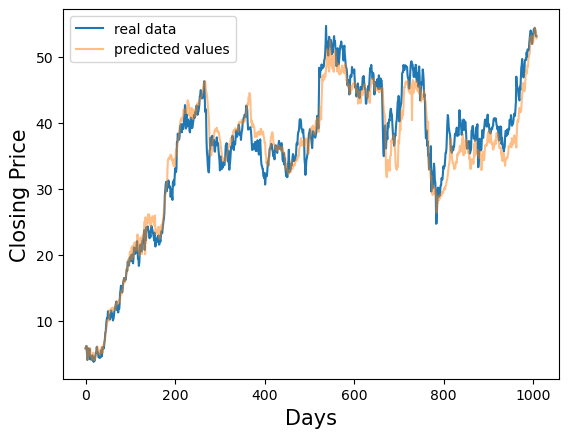

In [89]:
#test for 1 stock
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

checkpoint = 1070
state_dict = torch.load(os.path.join(current_path, "20-4-24", "Network2", "combinedCheckpoints", 'checkpoint' + str(checkpoint) + '.pth'))
model.load_state_dict(state_dict)
with torch.no_grad():
    model.eval()    
    inpt = [x[3][0] for x in test_data[0][0]]
    out = [x[3][0] for x in test_data[0][0]]
    for x, y in testloader:
        
        z = torch.transpose(x, 1, 2)
        market_index = z[:,0,:,1:]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]     
                   
        outputs = model(z, market_index)
        
        out.append(outputs.squeeze()[2])
        inpt.append(y.squeeze()[2])



#out1 = [out[i] + spline_inpt_smooth_prices[i] - spline_out_smooth_prices[i] for i in range(len(out))]
#out = out1
inpt = [inp*stds[3]+means[3] for inp in inpt]
out = [ot*stds[3]+means[3] in out]

prod1 = 1
for i in range(1, len(inpt)):
    sign = 1
    if out[i]-out[i-1] < 0:
        sign = -1
    prod1 *= (1+(inpt[i]-inpt[i-1])/inpt[i-1]*sign)

total_loss = 0.0
for i in range(len(inpt)-10):
    outpt = out[i+10].unsqueeze(0)
    total_loss += (inpt[i+10]-out[i+10])**2
total_loss/=(len(inpt)-10)


print(prod1, total_loss)

plt.plot(inpt, label='real data')
plt.plot(out, alpha=0.5, label='predicted values')

plt.xlabel('Days', fontsize=15)
plt.ylabel('Closing Price', fontsize=15)
plt.legend()
plt.show()

In [135]:
#bagging test for all 5 stocks

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

inpts = []
outs = []
for checkpoint in [960, 850, 1190, 1030, 780, 1390, 990, 1240, 1000, 1070]:
    state_dict = torch.load(os.path.join(current_path, "20-4-24", "Network2", "combinedCheckpoints", 'checkpoint' + str(checkpoint) + '.pth'))
    model.load_state_dict(state_dict)
    with torch.no_grad():
        model.eval()
        inpt = test_data[0][0][:,1:6,0]
        out = test_data[0][0][:,1:6,0]
        for x, y in testloader:

            z = torch.transpose(x, 1, 2)
            market_index = z[:,0,:,1:]
            market_index = torch.unsqueeze(market_index, 1)
            z = z[:, 1:]     

            outputs = model(z, market_index)

            out = torch.cat((out,outputs))

            inpt = torch.cat((inpt, y))
        inpts.append(inpt)
        outs.append(out)
        
inpts = torch.stack(inpts)
outs = torch.stack(outs)

torch.Size([10, 1008, 5])
tensor(1.2344) -0.03280070544664777 tensor(0.0525) tensor(0.0056, dtype=torch.float64)


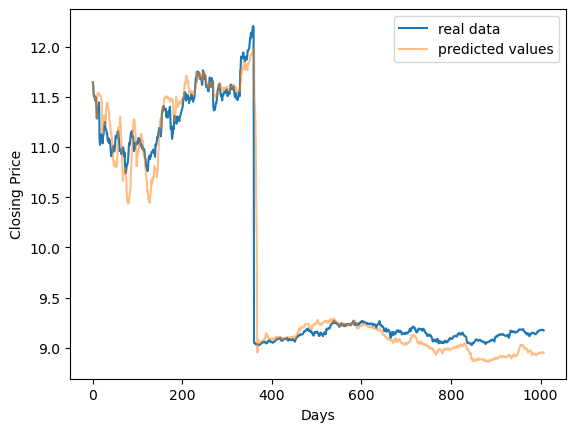

tensor(0.8962) -0.03280070544664777 tensor(0.3849) tensor(0.0056, dtype=torch.float64)


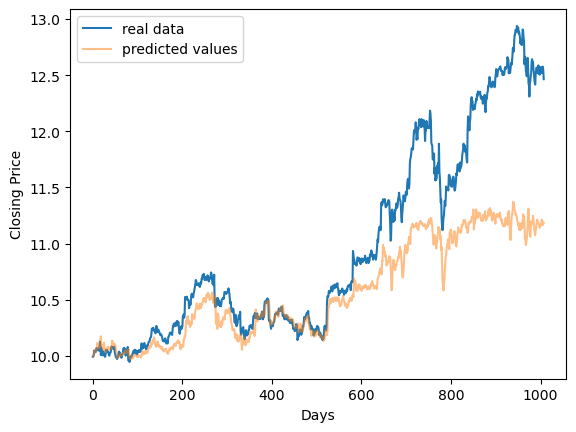

tensor(1.0699) -0.03280070544664777 tensor(0.0146) tensor(0.0056, dtype=torch.float64)


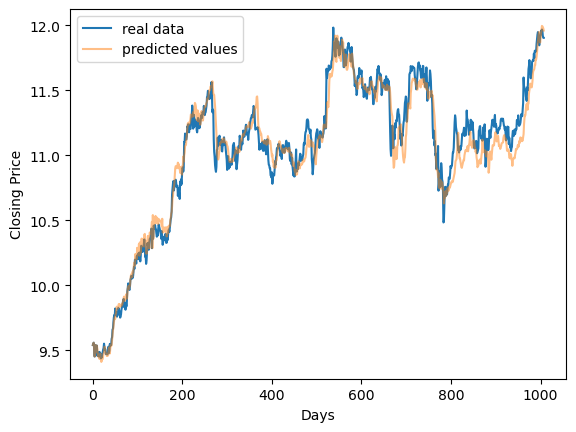

tensor(1.1419) -0.03280070544664777 tensor(0.0064) tensor(0.0056, dtype=torch.float64)


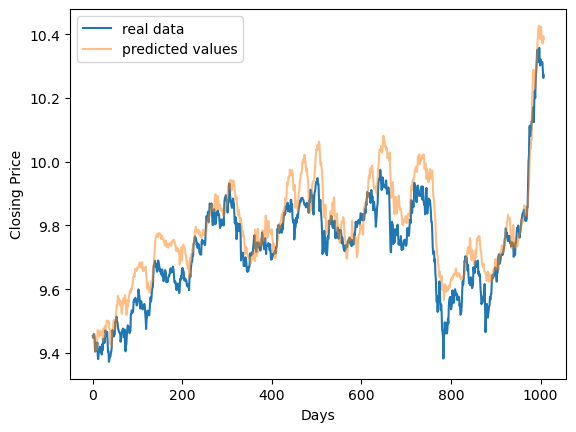

tensor(1.2178) -0.03280070544664777 tensor(0.0227) tensor(0.0056, dtype=torch.float64)


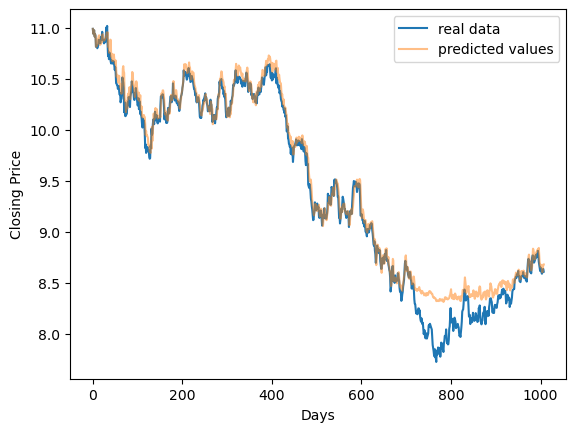

[tensor(1.2344), tensor(0.8962), tensor(1.0699), tensor(1.1419), tensor(1.2178)] [tensor(0.0525), tensor(0.3849), tensor(0.0146), tensor(0.0064), tensor(0.0227)] 1.1120489 0.096221365


In [140]:
#calculate results for all 5 stocks
inpts2 = torch.mean(inpts, dim=0) + 10 # +10 to avoid dividing by 0 in prod1
outs2 = torch.mean(outs, dim=0) + 10
prods = []
mses = []

for s in range(5):
    inpt = inpts2[:,s]
    out = outs2[:,s]
    
    prod1 = 1
    for j in range(1, len(inpt)):
        sign = 1
        if out[j]-out[j-1] < 0:
            sign = -1
        prod1 *= (1+((inpt[j]-inpt[j-1])/inpt[j-1]*sign))
    prods.append(prod1)


    total_loss = 0.0
    for j in range(len(inpt)-10):
        total_loss += (inpt[j+10]-out[j+10])**2
    total_loss/=(len(inpt)-10)
    mses.append(total_loss)


    print(prod1, prod2, total_loss, total_loss2)

    plt.plot(inpt, label='real data')
    plt.plot(out, alpha=0.5, label='predicted values')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
print(prods, mses, np.mean(prods), np.mean(mses))